In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from dapinet.analysis import (
    load_test_datasets_from_index,
    run_inference_on_test_datasets,
)

In [ ]:
print("=" * 80)
print("LOADING DATA")
print("=" * 80)

# Load test datasets index
parquet_path = "Path to .parquet"
print(f"\nLoading dataset index from: {parquet_path}")
test_df = load_test_datasets_from_index(parquet_path)

LOADING DATA

Loading dataset index from: datasets/synthetic_n1000_r10_v2/dataset_index.parquet
Total datasets in index: 50474
Test datasets: 5040


In [ ]:
print("\n" + "=" * 80)
print("RUNNING INFERENCE")
print("=" * 80 + "\n")

# Run inference on all test datasets
# Note: notebooks run with CWD = notebooks/, so models live one level up.
model_dir = "models/DAPINet"
results_df = run_inference_on_test_datasets(model_dir, test_df, verbose=True)

# Save results
output_path = "results/test_inference_results.csv"
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

2026-01-26 12:40:46,832 INFO: Found 5 models in models/training_54109677
2026-01-26 12:40:46,935 INFO: Updating Config from checkpoint_fold_1.pth...
2026-01-26 12:40:46,944 INFO: Loaded model from models/training_54109677\checkpoint_fold_1.pth (Epoch 4, Loss 0.0456)



RUNNING INFERENCE



2026-01-26 12:40:46,977 INFO: Updating Config from checkpoint_fold_2.pth...
2026-01-26 12:40:46,985 INFO: Loaded model from models/training_54109677\checkpoint_fold_2.pth (Epoch 8, Loss 0.0461)
2026-01-26 12:40:47,018 INFO: Updating Config from checkpoint_fold_3.pth...
2026-01-26 12:40:47,025 INFO: Loaded model from models/training_54109677\checkpoint_fold_3.pth (Epoch 9, Loss 0.0513)
2026-01-26 12:40:47,057 INFO: Updating Config from checkpoint_fold_4.pth...
2026-01-26 12:40:47,065 INFO: Loaded model from models/training_54109677\checkpoint_fold_4.pth (Epoch 7, Loss 0.0482)
2026-01-26 12:40:47,098 INFO: Updating Config from checkpoint_fold_5.pth...
2026-01-26 12:40:47,105 INFO: Loaded model from models/training_54109677\checkpoint_fold_5.pth (Epoch 8, Loss 0.0447)
Processing datasets: 100%|██████████| 5040/5040 [03:29<00:00, 24.03it/s]  



Results saved to: results/test_inference_results.csv


In [4]:
# Aggregate metrics from inference results
mean_mse = results_df["mse_loss"].mean()
mean_inference_time = results_df["inference_time_ms"].mean()

pred_stats = []
for _, row in results_df.iterrows():
    true_ari = np.asarray(row["ARI"])
    probs = np.asarray(row["predicted_probs"])
    pred_idx = int(np.argmax(probs))
    max_true_idx = int(np.argmax(true_ari))
    pred_ari = float(true_ari[pred_idx])
    max_true_ari = float(true_ari[max_true_idx])
    pred_stats.append(
        {
            "pred_idx": pred_idx,
            "pred_ari": pred_ari,
            "max_true_idx": max_true_idx,
            "max_true_ari": max_true_ari,
        }
    )

pred_df = pd.DataFrame(pred_stats)
pred_df["regret"] = pred_df["max_true_ari"] - pred_df["pred_ari"]

mean_pred_ari = pred_df["pred_ari"].mean()
median_pred_ari = pred_df["pred_ari"].median()

mean_true_max_ari = pred_df["max_true_ari"].mean()
median_true_max_ari = pred_df["max_true_ari"].median()

mean_regret = pred_df["regret"].mean()
median_regret = pred_df["regret"].median()

# Accuracy when choosing the index with the highest ARI
correct_choice_pct = (pred_df["pred_ari"] == pred_df["max_true_ari"]).mean() * 100

# How often the predicted ARI is within 10% of the maximum ARI
within_10_pct = (pred_df["pred_ari"] >= pred_df["max_true_ari"] - 0.1).mean() * 100

print("=== Inference Summary ===")
print(f"Mean MSE loss: {mean_mse:.6f}")
print(f"Mean inference time (ms): {mean_inference_time:.2f}")
print(f"Predicted ARI - mean: {mean_pred_ari:.6f}, median: {median_pred_ari:.6f}")
print(f"True max ARI - mean: {mean_true_max_ari:.6f}, median: {median_true_max_ari:.6f}")
print(f"Regret - mean: {mean_regret:.6f}, median: {median_regret:.6f}")
print(f"Correct top-ARI choice: {correct_choice_pct:.2f}%")
print(f"Predicted ARI within -0.1 of max ARI: {within_10_pct:.2f}%")

=== Inference Summary ===
Mean MSE loss: 0.039416
Mean inference time (ms): 37.37
Predicted ARI - mean: 0.624025, median: 0.658107
True max ARI - mean: 0.691977, median: 0.789108
Regret - mean: 0.067952, median: 0.000000
Correct top-ARI choice: 53.47%
Predicted ARI within -0.1 of max ARI: 79.13%


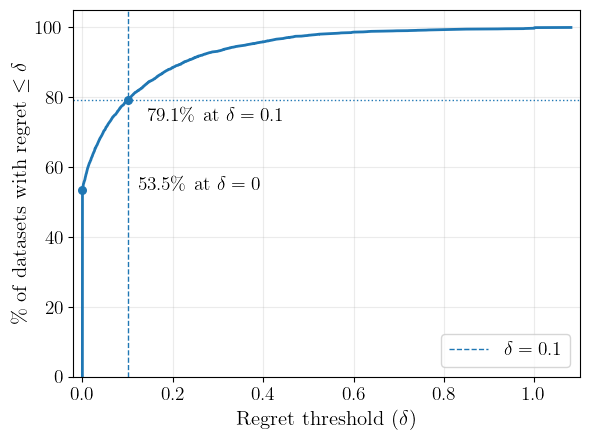

% of datasets with regret ≤ 0.0: 53.47%
% of datasets with regret ≤ 0.1: 79.13%


In [ ]:
regret = (pred_df["max_true_ari"] - pred_df["pred_ari"]).astype(float)
regret_values = np.asarray(regret.dropna(), dtype=float)
regret_values = np.sort(regret_values)

# Empirical CDF
cdf_y = np.arange(1, len(regret_values) + 1) / len(regret_values)
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.titlesize": 22,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
    }
)
# Reference thresholds
eps0 = 0.0
eps1 = 0.1
pct_at_0 = 100.0 * float(np.mean(regret_values <= eps0))
pct_at_01 = 100.0 * float(np.mean(regret_values <= eps1))
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(regret_values, cdf_y * 100.0, linewidth=2)
ax.set_xlabel(r"Regret threshold ($\delta$)", fontsize=15)
ax.set_ylabel(r"\% of datasets with regret $\leq \delta$", fontsize=15)  # Escape %
ax.set_ylim(0, 105)
ax.set_xlim(-0.02, regret_values.max() + 0.02)
ax.grid(True, alpha=0.25)
# Visual marker at δ = 0.1
ax.axvline(eps1, linestyle="--", linewidth=1, label=r"$\delta=0.1$")
ax.axhline(pct_at_01, linestyle=":", linewidth=1)
# Annotate key points
ax.scatter([eps0, eps1], [pct_at_0, pct_at_01], s=30, zorder=5)
ax.annotate(
    f"{pct_at_0:.1f}" + r"\% at $\delta=0$",  # Escape % for LaTeX
    (eps0, pct_at_0),
    textcoords="offset points",
    xytext=(40, 0),
    fontsize=14,
)
ax.annotate(
    f"{pct_at_01:.1f}" + r"\% at $\delta=0.1$",  # Escape % for LaTeX
    (eps1, pct_at_01),
    textcoords="offset points",
    xytext=(15, -15),
    fontsize=14,
)
ax.legend(loc="lower right", fontsize=14)
fig.tight_layout()
fig.savefig(
    "results/figures/regret_cdf.pdf",
    format="pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.show()
print(f"% of datasets with regret ≤ 0.0: {pct_at_0:.2f}%")
print(f"% of datasets with regret ≤ 0.1: {pct_at_01:.2f}%")

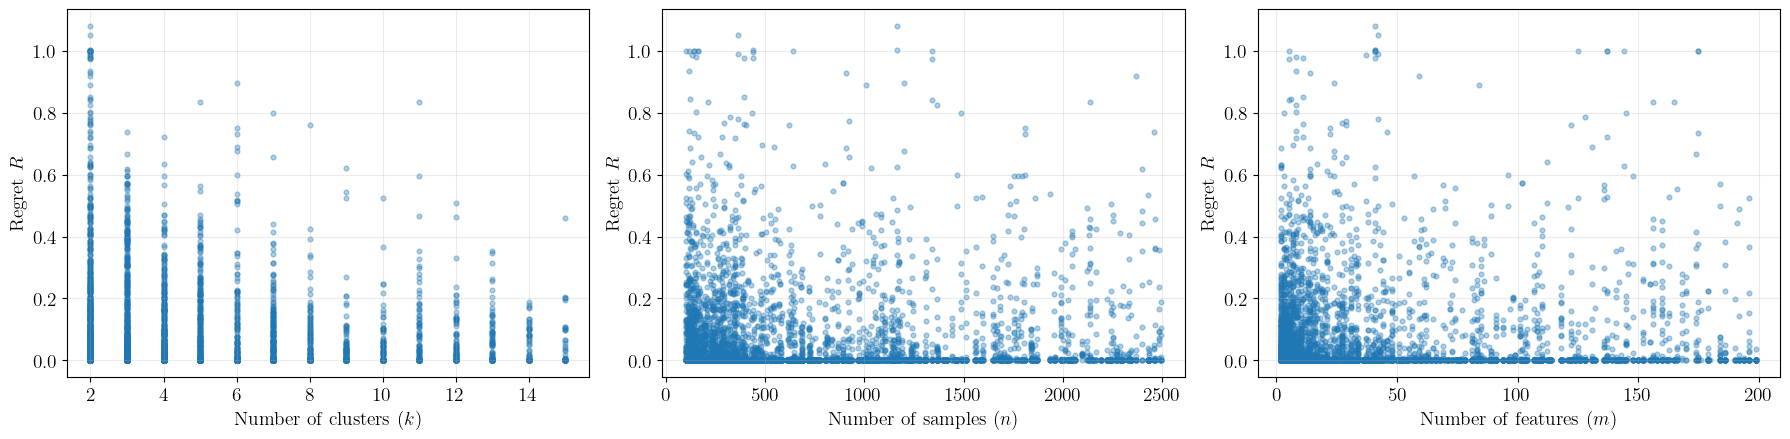

Spearman correlation coefficients: k=0.04388577827668202, n=-0.1257464373231686, d=-0.1275530638018205


In [14]:
# 2. Update rcParams BEFORE creating the figure
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.titlesize": 22,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
    }
)
# 3. Prepare data
df_stress = results_df.reset_index(drop=True).copy()
df_stress["regret"] = np.asarray(regret.reset_index(drop=True), dtype=float)

k_col, n_col, d_col = "num_clusters", "num_samples", "num_features"
for col in [k_col, n_col, d_col]:
    if col not in df_stress.columns:
        raise KeyError(f"Missing column: {col}. Available: {list(df_stress.columns)}")

# 4. Calculate correlations
spearman_k = df_stress[["regret", k_col]].corr(method="spearman").iloc[0, 1]
spearman_n = df_stress[["regret", n_col]].corr(method="spearman").iloc[0, 1]
spearman_d = df_stress[["regret", d_col]].corr(method="spearman").iloc[0, 1]

# 5. Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

configs = [
    (axes[0], k_col, "Number of clusters ($k$)"),
    (axes[1], n_col, "Number of samples ($n$)"),
    (axes[2], d_col, "Number of features ($m$)"),
]

for ax, col, label in configs:
    ax.scatter(df_stress[col], df_stress["regret"], alpha=0.35, s=12)
    ax.set_xlabel(label)
    ax.set_ylabel("Regret $R$")
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.savefig(
    "results/figures/sensitivity_analysis.pdf",
    format="pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.show()
print(f"Spearman correlation coefficients: k={spearman_k}, n={spearman_n}, d={spearman_d}")